## Question 1

In [ ]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

### a) Extraction des données WRDS pour 50 sociétés du S&P 500

L'article utilise des données mensuelles. Nous allons extraire:
- Prix mensuels des actions (CRSP)
- Bénéfice par action - EPS (IBES)
- Calculer le ratio P/E glissant (trailing P/E)

In [ ]:
# Connexion à WRDS
db = wrds.Connection(wrds_username='vince1209')

Loading library list...
Done
Done


In [ ]:
# Définir la période d'analyse (ajustez selon l'article)
# L'article utilise typiquement des données de 1985 à 2015 environ
start_date = '2003-01-01'
end_date = '2023-12-31'

n_compagnies = 50
np.random.seed(42)

In [ ]:
# Étape 1: Récupérer la liste des constituants du S&P 500 avec leurs noms et tickers

# Choisir le type de sélection
current_sp500_only = False  # False = toutes les sociétés qui ont été dans le S&P 500 entre 2003 et 2023

# Requête modifiée pour capturer toutes les sociétés qui ont été dans le S&P 500 
# à n'importe quel moment pendant la période 2003-2023
query_sp500 = """
SELECT DISTINCT sp.permno, n.comnam, n.ticker
FROM crsp.dsp500list sp
JOIN crsp.msenames n ON sp.permno = n.permno
WHERE sp.start <= '{end_date}'
  AND sp.ending >= '{start_date}'
  AND n.namedt <= '{end_date}'
  AND n.nameendt >= '{start_date}'
ORDER BY sp.permno
""".format(start_date=start_date, end_date=end_date)

print(f"Récupération de toutes les sociétés qui ont été dans le S&P 500 entre {start_date} et {end_date}...")
sp500_data = db.raw_sql(query_sp500)

print(f"Nombre total de lignes récupérées: {len(sp500_data)}")
print(f"Nombre de PERMNO uniques: {sp500_data['permno'].nunique()}")
print(f"Nombre de TICKER uniques: {sp500_data['ticker'].nunique()}")


# Garder seulement les permno uniques (le ticker le plus récent)
sp500_constituents = sp500_data.drop_duplicates(subset=['permno'], keep='last')

print(f"\nNombre total de sociétés S&P 500 trouvées: {len(sp500_constituents)}")
print("\nPremières lignes:")
print(sp500_constituents.head(10))


Récupération de toutes les sociétés qui ont été dans le S&P 500 entre 2003-01-01 et 2023-12-31...
Nombre total de lignes récupérées: 1344
Nombre de PERMNO uniques: 967
Nombre de TICKER uniques: 1092

Nombre total de sociétés S&P 500 trouvées: 967

Premières lignes:
    permno                       comnam ticker
1    10078         SUN MICROSYSTEMS INC   SUNW
2    10104                  ORACLE CORP   ORCL
3    10107               MICROSOFT CORP   MSFT
4    10108     SUNGARD DATA SYSTEMS INC    SDS
5    10137         ALLEGHENY ENERGY INC    AYE
6    10138       T ROWE PRICE GROUP INC   TROW
7    10145  HONEYWELL INTERNATIONAL INC    HON
8    10147                E M C CORP MA    EMC
10   10225           FORTUNE BRANDS INC     FO
11   10299       LINEAR TECHNOLOGY CORP   LLTC


In [ ]:
# Étape 2: Sélectionner aléatoirement 50 sociétés avec données disponibles entre 2003 et 2023
# Filtrer pour avoir uniquement des sociétés avec des données valides
sp500_valid = sp500_constituents[sp500_constituents['permno'].notna()].copy()

print(f"Nombre de sociétés candidates: {len(sp500_valid)}")
print("Vérification de la disponibilité des données pour chaque société...")

# Récupérer les PERMNOs candidats
candidate_permnos = sp500_valid['permno'].tolist()
permnos_str_temp = ','.join(map(str, candidate_permnos))

# Requête pour compter le nombre d'observations mensuelles par société
query_data_availability = """
SELECT 
    permno,
    COUNT(*) as num_observations,
    MIN(date) as first_date,
    MAX(date) as last_date
FROM crsp.msf
WHERE permno IN ({permnos})
  AND date >= '{start_date}'
  AND date <= '{end_date}'
  AND prc IS NOT NULL
GROUP BY permno
ORDER BY num_observations DESC
""".format(permnos=permnos_str_temp, start_date=start_date, end_date=end_date)

data_availability = db.raw_sql(query_data_availability)

print(f"\nSociétés avec des données: {len(data_availability)}")

# Définir un seuil minimum d'observations (par exemple, au moins 12 mois de données)
min_observations = 12
companies_with_data = data_availability[data_availability['num_observations'] >= min_observations]

print(f"Sociétés avec au moins {min_observations} observations: {len(companies_with_data)}")

# Fusionner avec sp500_valid pour garder les informations complètes
sp500_with_data = sp500_valid.merge(
    companies_with_data[['permno', 'num_observations', 'first_date', 'last_date']], 
    on='permno', 
    how='inner'
)

# Trier par nombre d'observations (pour favoriser les sociétés avec plus de données)
sp500_with_data = sp500_with_data.sort_values('num_observations', ascending=False)

# Sélection aléatoire parmi les sociétés avec données
n_companies = 50
if len(sp500_with_data) >= n_companies:
    # Prendre un échantillon aléatoire
    selected_companies = sp500_with_data.sample(n=n_companies, random_state=42)
    print(f"\n✓ {n_companies} sociétés sélectionnées aléatoirement avec données disponibles")
else:
    print(f"\n⚠ Attention: Seulement {len(sp500_with_data)} sociétés disponibles avec données")
    selected_companies = sp500_with_data

# Récupérer les PERMNOs pour les requêtes futures
permnos = selected_companies['permno'].tolist()
permnos_str = ','.join(map(str, permnos))

# Reset index
selected_companies = selected_companies.sort_values('num_observations', ascending=False).reset_index(drop=True)

print(f"\n{'='*70}")
print("SOCIÉTÉS SÉLECTIONNÉES")
print(f"{'='*70}")
print(f"\nNombre de sociétés: {len(selected_companies)}")
print(f"\nStatistiques de couverture:")
print(f"  - Observations moyennes par société: {selected_companies['num_observations'].mean():.0f}")
print(f"  - Min: {selected_companies['num_observations'].min()}")
print(f"  - Max: {selected_companies['num_observations'].max()}")

print(f"\n{'='*70}")
print("LISTE DES SOCIÉTÉS")
print(f"{'='*70}")
print(selected_companies[['permno', 'comnam', 'ticker', 'num_observations', 'first_date', 'last_date']].to_string())


In [ ]:
# Étape 3: Extraire les prix journaliers des actions depuis CRSP
# Utilisation de la table crsp.dsf (Daily Stock File)

query_prices_d = """
SELECT 
    a.permno,
    a.date,
    a.prc,
    a.ret,
    a.shrout,
    a.cfacpr,
    a.cfacshr,
    ABS(a.prc) as price,
    ABS(a.prc) * a.shrout as market_cap
FROM crsp.dsf as a
WHERE a.permno IN ({permnos})
  AND a.date >= '{start_date}'
  AND a.date <= '{end_date}'
ORDER BY a.permno, a.date
""".format(permnos=permnos_str, start_date=start_date, end_date=end_date)

print("Extraction des prix journaliers depuis CRSP...")
daily_prices = db.raw_sql(query_prices_d)

# Convertir la date en datetime
daily_prices['date'] = pd.to_datetime(daily_prices['date'])

print(f"Nombre total d'observations: {len(daily_prices):,}")
print(f"\nPériode couverte: {daily_prices['date'].min()} à {daily_prices['date'].max()}")
print(f"Nombre de jours de trading: {daily_prices['date'].nunique():,}")
print(f"\nPremières lignes:")
print(daily_prices)

Extraction des prix journaliers depuis CRSP...
Nombre total d'observations: 264,250

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:
        permno       date    prc       ret     shrout  cfacpr  cfacshr  price  \
0        10104 2003-01-02  11.21  0.037963  5269114.0     1.0      1.0  11.21   
1        10104 2003-01-03  11.56  0.031222  5269114.0     1.0      1.0  11.56   
2        10104 2003-01-06  11.96  0.034602  5269114.0     1.0      1.0  11.96   
3        10104 2003-01-07  12.69  0.061037  5269114.0     1.0      1.0  12.69   
4        10104 2003-01-08  12.12 -0.044917  5269114.0     1.0      1.0  12.12   
...        ...        ...    ...       ...        ...     ...      ...    ...   
264245   89508 2023-12-22  76.52 -0.025844   158668.0     1.0      1.0  76.52   
264246   89508 2023-12-26  76.18 -0.004443   158668.0     1.0      1.0  76.18   
264247   89508 2023-12-27   78.0  0.023891   158668.0     1.0      1.0   

In [ ]:
# Étape 3.2: Extraire les prix journaliers des actions depuis CRSP
# Utilisation de la table crsp.dsf (Daily Stock File)

query_prices_m = """
SELECT 
    a.permno,
    a.date,
    a.prc,
    a.ret,
    a.shrout,
    a.cfacpr,
    a.cfacshr,
    ABS(a.prc) as price,
    ABS(a.prc) * a.shrout as market_cap
FROM crsp.msf as a
WHERE a.permno IN ({permnos})
  AND a.date >= '{start_date}'
  AND a.date <= '{end_date}'
ORDER BY a.permno, a.date
""".format(permnos=permnos_str, start_date=start_date, end_date=end_date)

print("Extraction des prix journaliers depuis CRSP...")
monthly_prices = db.raw_sql(query_prices_m)

# Convertir la date en datetime
daily_prices['date'] = pd.to_datetime(daily_prices['date'])

print(f"Nombre total d'observations: {len(daily_prices):,}")
print(f"\nPériode couverte: {daily_prices['date'].min()} à {daily_prices['date'].max()}")
print(f"Nombre de jours de trading: {daily_prices['date'].nunique():,}")
print(f"\nPremières lignes:")

monthly_prices

Extraction des prix journaliers depuis CRSP...
Nombre total d'observations: 229,769

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:
Nombre total d'observations: 229,769

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:


,permno,date,prc,ret,shrout,cfacpr,cfacshr,price,market_cap
0,10104,2003-01-31,12.03,0.113889,5269114.0,1.0,1.0,12.03,63387441.42
1,10104,2003-02-28,11.96,-0.005819,5242000.0,1.0,1.0,11.96,62694320.0
2,10104,2003-03-31,10.849,-0.092893,5242996.0,1.0,1.0,10.849,56881263.604
3,10104,2003-04-30,11.88,0.095032,5242996.0,1.0,1.0,11.88,62286792.48
4,10104,2003-05-30,13.01,0.095118,5233000.0,1.0,1.0,13.01,68081330.0
...,...,...,...,...,...,...,...,...,...
10973,93096,2023-08-31,138.5,-0.179794,219341.0,1.0,1.0,138.5,30378728.5
10974,93096,2023-09-29,105.8,-0.236101,219476.0,1.0,1.0,105.8,23220560.8
10975,93096,2023-10-31,119.04,0.130718,219476.0,1.0,1.0,119.04,26126423.04
10976,93096,2023-11-30,131.12,0.101478,219476.0,1.0,1.0,131.12,28777693.12


In [ ]:
# Étape 4: Obtenir la correspondance PERMNO-TICKER pour IBES
# Utiliser les tickers déjà récupérés dans selected_companies

# On utilise directement les tickers de selected_companies pour éviter les doublons
permno_ticker_link = selected_companies[['permno', 'ticker']].copy()

# Obtenir les tickers uniques (filtrer les valeurs nulles)
tickers = permno_ticker_link[permno_ticker_link['ticker'].notna()]['ticker'].unique().tolist()
tickers_str = "','".join(tickers)

print(f"Nombre de sociétés: {len(permno_ticker_link)}")
print(f"Nombre de tickers uniques: {len(tickers)}")
print("\nCorrespondances PERMNO-TICKER:")
print(permno_ticker_link)

Nombre de sociétés: 50
Nombre de tickers uniques: 50

Correspondances PERMNO-TICKER:
    permno ticker
0    63467    BRO
1    15579    TXN
2    70519      C
3    24985    AEE
4    18729     CL
5    66093    SBC
6    85592    PLD
7    21936    PFE
8    15069    MRO
9    58413    FRT
10   11533   FICO
11   41080    CUM
12   75828   ERTS
13   17005    CVS
14   83143    IRM
15   85348    YUM
16   93096     DG
17   12623    HII
18   76795   ZBRA
19   86580   NVDA
20   92611      V
21   92614    AWK
22   52038    SYY
23   52230    RHI
24   15850   MTCH
25   90455   MPWR
26   90993    ICE
27   86158   CTSH
28   18576   UBER
29   79103   ORLY
30   75186   SCHW
31   49680    DHR
32   91041    LYV
33   30681    OMC
34   10138   TROW
35   79094    JBL
36   64390    PGR
37   15291   ETSY
38   45911   SWKS
39   14763   CTLT
40   80100    SPG
41   18143    LIN
42   92157    TEL
43   37584    BEN
44   13103   DLPH
45   16087    FTV
46   10104   ORCL
47   11618   FAST
48   76226    VIA
49   12345    L

In [ ]:
# Étape 5: Extraire les données EPS actuelles (Actual EPS) depuis IBES
# Utilisation de la table ibes.act_epsus (Actual EPS)

query_actual_eps = """
SELECT 
    ticker,
    pends,
    anndats,
    value as actual_eps,
    curr_act as currency
FROM ibes.act_epsus
WHERE ticker IN ('{tickers}')
  AND anndats >= '{start_date}'
  AND anndats <= '{end_date}'
  AND pdicity = 'ANN'
ORDER BY ticker, pends
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

print("Extraction des EPS actuels depuis IBES...")
actual_eps = db.raw_sql(query_actual_eps)

# Convertir les dates
actual_eps['pends'] = pd.to_datetime(actual_eps['pends'])
actual_eps['anndats'] = pd.to_datetime(actual_eps['anndats'])

print(f"Nombre d'observations EPS actuels: {len(actual_eps)}")
print(f"Nombre de tickers avec EPS: {actual_eps['ticker'].nunique()}")

# Afficher le nombre d'EPS par ticker
eps_count_per_ticker = actual_eps.groupby('ticker').size().sort_values(ascending=False)
print(f"\nNombre d'EPS par ticker:")
print(eps_count_per_ticker)

print(f"\nStatistiques: Min={eps_count_per_ticker.min()}, Max={eps_count_per_ticker.max()}, Moyenne={eps_count_per_ticker.mean():.1f}")

print(f"\nPremières lignes:")
actual_eps

Extraction des EPS actuels depuis IBES...
Nombre d'observations EPS actuels: 432
Nombre de tickers avec EPS: 25

Nombre d'EPS par ticker:
ticker
CL      21
ORCL    21
YUM     21
VIA     21
TXN     21
SYY     21
SBC     21
PFE     21
ORLY    21
NVDA    21
FRT     21
FAST    21
ERTS    21
DLPH    21
CUM     21
CTSH    21
ZBRA    21
MPWR    20
LYV     19
CTLT    10
ETSY     9
SPG      5
UBER     5
PGR      4
LIN      3
dtype: int64

Statistiques: Min=3, Max=21, Moyenne=17.3

Premières lignes:


,ticker,pends,anndats,actual_eps,currency
0,CL,2002-12-31,2003-02-04,1.095,USD
1,CL,2003-12-31,2004-02-03,1.23,USD
2,CL,2004-12-31,2005-01-27,1.21,USD
3,CL,2005-12-31,2006-01-25,1.32,USD
4,CL,2006-12-31,2007-01-30,1.455,USD
...,...,...,...,...,...
427,ZBRA,2018-12-31,2019-02-14,11.01,USD
428,ZBRA,2019-12-31,2020-02-13,12.94,USD
429,ZBRA,2020-12-31,2021-02-11,12.8,USD
430,ZBRA,2021-12-31,2022-02-10,18.45,USD


In [ ]:
# Diagnostic: Identifier les tickers sans données EPS

# Tickers sélectionnés vs tickers avec EPS
tickers_selected = set(selected_companies['ticker'].dropna())
tickers_with_eps = set(actual_eps['ticker'].unique())
tickers_without_eps = tickers_selected - tickers_with_eps

print("="*70)
print("DIAGNOSTIC DES DONNÉES EPS")
print("="*70)

print(f"\n✓ Tickers sélectionnés: {len(tickers_selected)}")
print(f"✓ Tickers avec EPS dans IBES: {len(tickers_with_eps)}")
print(f"✗ Tickers SANS données EPS: {len(tickers_without_eps)}")

if len(tickers_without_eps) > 0:
    print(f"\nTickers manquants dans IBES:")
    # Trouver les noms des sociétés correspondantes
    missing_companies = selected_companies[selected_companies['ticker'].isin(tickers_without_eps)]
    print(missing_companies[['ticker', 'comnam']].to_string(index=False))
    
print("\n" + "="*70)
print("COUVERTURE TEMPORELLE PAR TICKER")
print("="*70)

# Analyser la couverture temporelle pour chaque ticker
coverage = actual_eps.groupby('ticker').agg({
    'pends': ['min', 'max', 'count']
}).round(2)
coverage.columns = ['Première année', 'Dernière année', 'Nombre EPS']
coverage = coverage.sort_values('Nombre EPS', ascending=False)

print(f"\nCouverture par ticker:")
print(coverage)

DIAGNOSTIC DES DONNÉES EPS

✓ Tickers sélectionnés: 50
✓ Tickers avec EPS dans IBES: 25
✗ Tickers SANS données EPS: 25

Tickers manquants dans IBES:
ticker                        comnam
   BRO             BROWN & BROWN INC
     C                 CITIGROUP INC
   AEE                   AMEREN CORP
   PLD                  PROLOGIS INC
   MRO             MARATHON OIL CORP
  FICO               FAIR ISAAC CORP
   CVS             C V S HEALTH CORP
   IRM         IRON MOUNTAIN INC NEW
    DG       DOLLAR GENERAL CORP NEW
   HII   HUNTINGTON INGALLS INDS INC
     V                      VISA INC
   AWK   AMERICAN WATER WORKS CO INC
   RHI ROBERT HALF INTERNATIONAL INC
  MTCH           MATCH GROUP INC NEW
   ICE  INTERCONTINENTALEXCHANGE INC
  SCHW       SCHWAB CHARLES CORP NEW
   DHR                  DANAHER CORP
   OMC             OMNICOM GROUP INC
  TROW        T ROWE PRICE GROUP INC
   JBL                     JABIL INC
  SWKS        SKYWORKS SOLUTIONS INC
   TEL      TYCO ELECTRONICS LTD NEW


In [ ]:
# Étape 6: Extraire les prévisions EPS (Consensus Forecasts) depuis IBES
# Utilisation de la table ibes.statsum_epsus (Summary Statistics)

query_forecast_eps = """
SELECT 
    ticker,
    statpers,
    fpedats,
    numest,
    medest,
    meanest,
    stdev,
    actual
FROM ibes.statsum_epsus
WHERE ticker IN ('{tickers}')
  AND statpers >= '{start_date}'
  AND statpers <= '{end_date}'
  AND fpi = '1'
  AND measure = 'EPS'
ORDER BY ticker, statpers
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

print("Extraction des prévisions EPS depuis IBES...")
forecast_eps = db.raw_sql(query_forecast_eps)

# Convertir les dates
forecast_eps['statpers'] = pd.to_datetime(forecast_eps['statpers'])
forecast_eps['fpedats'] = pd.to_datetime(forecast_eps['fpedats'])

print(f"Nombre d'observations de prévisions: {len(forecast_eps)}")
print(f"\nPremières lignes:")

forecast_eps

Extraction des prévisions EPS depuis IBES...
Nombre d'observations de prévisions: 4970

Premières lignes:
Nombre d'observations de prévisions: 4970

Premières lignes:


,ticker,statpers,fpedats,numest,medest,meanest,stdev,actual
0,AWK,2003-01-16,2002-12-31,1.0,1.5,1.5,<NA>,<NA>
1,CL,2003-01-16,2002-12-31,12.0,1.1,1.09,0.0,1.095
2,CL,2003-02-20,2003-12-31,12.0,1.22,1.22,0.01,1.23
3,CL,2003-03-20,2003-12-31,12.0,1.22,1.22,0.01,1.23
4,CL,2003-04-17,2003-12-31,12.0,1.22,1.22,0.01,1.23
...,...,...,...,...,...,...,...,...
4965,ZBRA,2023-08-17,2023-12-31,12.0,9.59,9.72,0.46,9.82
4966,ZBRA,2023-09-14,2023-12-31,11.0,9.61,9.74,0.45,9.82
4967,ZBRA,2023-10-19,2023-12-31,13.0,9.61,9.64,0.49,9.82
4968,ZBRA,2023-11-16,2023-12-31,12.0,9.74,9.69,0.32,9.82


In [ ]:
# Étape 7: Fusionner les données et calculer le ratio P/E glissant (Trailing P/E)

# 7.1: Merger PERMNO avec TICKER
permno_ticker_unique = permno_ticker_link.drop_duplicates(subset=['permno'], keep='first')
monthly_prices_with_ticker = monthly_prices.merge(
    permno_ticker_unique[['permno', 'ticker']], 
    on='permno', 
    how='left'
)

print("Fusion des prix avec les tickers...")
print(f"Observations après fusion: {len(monthly_prices_with_ticker)}")

# 7.2: Pour chaque date de prix, trouver le dernier EPS annuel disponible
# Créer une clé de fusion basée sur l'année-mois
monthly_prices_with_ticker['year_month'] = monthly_prices_with_ticker['date'].dt.to_period('M')

# Préparer les données EPS actuels pour la fusion
actual_eps['year_month_announced'] = actual_eps['anndats'].dt.to_period('M')

# Trier par ticker et date d'annonce
actual_eps_sorted = actual_eps.sort_values(['ticker', 'anndats'])

print("\nFusion avec les EPS actuels...")

Fusion des prix avec les tickers...
Observations après fusion: 10978

Fusion avec les EPS actuels...


In [ ]:
# 7.3: Calculer le trailing P/E en utilisant le dernier EPS disponible à chaque date
# Pour chaque observation de prix, on utilise le dernier EPS annoncé avant cette date

# Fonction pour calculer le trailing P/E
def calculate_trailing_pe(prices_df, eps_df):
    """
    Calcule le ratio P/E glissant en utilisant le dernier EPS disponible
    """
    result_list = []
    
    # Pour chaque ticker
    for ticker in prices_df['ticker'].unique():
        if pd.isna(ticker):
            continue
            
        # Filtrer les données pour ce ticker
        ticker_prices = prices_df[prices_df['ticker'] == ticker].copy()
        ticker_eps = eps_df[eps_df['ticker'] == ticker].copy()
        
        if len(ticker_eps) == 0:
            continue
        
        # Pour chaque date de prix
        for idx, row in ticker_prices.iterrows():
            price_date = row['date']
            
            # Trouver le dernier EPS annoncé avant cette date
            available_eps = ticker_eps[ticker_eps['anndats'] <= price_date]
            
            if len(available_eps) > 0:
                # Prendre le dernier EPS disponible
                latest_eps = available_eps.sort_values('anndats').iloc[-1]
                
                result_list.append({
                    'permno': row['permno'],
                    'ticker': ticker,
                    'date': price_date,
                    'price': row['price'],
                    'ret': row['ret'],
                    'market_cap': row['market_cap'],
                    'eps': latest_eps['actual_eps'],
                    'eps_date': latest_eps['pends'],
                    'eps_announced': latest_eps['anndats']
                })
    
    return pd.DataFrame(result_list)

print("Calcul du ratio P/E glissant...")
merged_data = calculate_trailing_pe(monthly_prices_with_ticker, actual_eps_sorted)

# Calculer le ratio P/E
merged_data['trailing_pe'] = merged_data['price'] / merged_data['eps']

# Filtrer les valeurs aberrantes (P/E négatifs ou extrêmes)
merged_data = merged_data[
    (merged_data['eps'] > 0) & 
    (merged_data['trailing_pe'] > 0) & 
    (merged_data['trailing_pe'] < 100)
]

print(f"\nNombre d'observations finales: {len(merged_data)}")
print(f"Nombre de sociétés avec données: {merged_data['ticker'].nunique()}")
print(f"\nPremières lignes:")
print(merged_data.head(10))

Calcul du ratio P/E glissant...

Nombre d'observations finales: 4120
Nombre de sociétés avec données: 20

Premières lignes:
   permno ticker       date  price       ret   market_cap   eps   eps_date  \
0   10104   ORCL 2003-06-30  12.01 -0.076864  62857613.73  0.44 2003-05-31   
1   10104   ORCL 2003-07-31  11.99 -0.001665  62752938.27  0.44 2003-05-31   
2   10104   ORCL 2003-08-29  12.83  0.070058   67023920.0  0.44 2003-05-31   
3   10104   ORCL 2003-09-30  11.25 -0.123149   58799767.5  0.44 2003-05-31   
4   10104   ORCL 2003-10-31  11.97     0.064  62562952.62  0.44 2003-05-31   
5   10104   ORCL 2003-11-28  12.02  0.004177   62816520.0  0.44 2003-05-31   
6   10104   ORCL 2003-12-31  13.23  0.100665  69160976.01  0.44 2003-05-31   
7   10104   ORCL 2004-01-30  13.86  0.047619  72454355.82  0.44 2003-05-31   
8   10104   ORCL 2004-02-27  12.87 -0.071429   66859650.0  0.44 2003-05-31   
9   10104   ORCL 2004-03-31   12.0 -0.067599   62339856.0  0.44 2003-05-31   

  eps_announced t

In [ ]:
# Étape 8: Ajouter les prévisions EPS (Expected EPS) aux données
# Fusion avec les prévisions consensus

def add_forecast_eps(data_df, forecast_df):
    """
    Ajoute les prévisions EPS aux données en utilisant la date la plus proche
    """
    result_list = []
    
    for idx, row in data_df.iterrows():
        ticker = row['ticker']
        price_date = row['date']
        
        # Trouver la prévision la plus récente avant ou à cette date
        ticker_forecasts = forecast_df[
            (forecast_df['ticker'] == ticker) & 
            (forecast_df['statpers'] <= price_date)
        ]
        
        if len(ticker_forecasts) > 0:
            # Prendre la prévision la plus récente
            latest_forecast = ticker_forecasts.sort_values('statpers').iloc[-1]
            
            row_dict = row.to_dict()
            row_dict['expected_eps'] = latest_forecast['meanest']
            row_dict['median_eps'] = latest_forecast['medest']
            row_dict['num_analysts'] = latest_forecast['numest']
            row_dict['forecast_date'] = latest_forecast['statpers']
            result_list.append(row_dict)
        else:
            # Pas de prévision disponible
            row_dict = row.to_dict()
            row_dict['expected_eps'] = np.nan
            row_dict['median_eps'] = np.nan
            row_dict['num_analysts'] = np.nan
            row_dict['forecast_date'] = pd.NaT
            result_list.append(row_dict)
    
    return pd.DataFrame(result_list)

print("Ajout des prévisions EPS...")
final_data = add_forecast_eps(merged_data, forecast_eps)

# Calculer le forward P/E basé sur les prévisions
final_data['forward_pe'] = final_data['price'] / final_data['expected_eps']

print(f"\nDonnées finales avec prévisions: {len(final_data)} observations")
print(f"Observations avec prévisions: {final_data['expected_eps'].notna().sum()}")
print(f"\nPremières lignes:")
print(final_data.head(10))

Ajout des prévisions EPS...

Données finales avec prévisions: 4120 observations
Observations avec prévisions: 4120

Premières lignes:
   permno ticker       date  price       ret   market_cap   eps   eps_date  \
0   10104   ORCL 2003-06-30  12.01 -0.076864  62857613.73  0.44 2003-05-31   
1   10104   ORCL 2003-07-31  11.99 -0.001665  62752938.27  0.44 2003-05-31   
2   10104   ORCL 2003-08-29  12.83  0.070058  67023920.00  0.44 2003-05-31   
3   10104   ORCL 2003-09-30  11.25 -0.123149  58799767.50  0.44 2003-05-31   
4   10104   ORCL 2003-10-31  11.97  0.064000  62562952.62  0.44 2003-05-31   
5   10104   ORCL 2003-11-28  12.02  0.004177  62816520.00  0.44 2003-05-31   
6   10104   ORCL 2003-12-31  13.23  0.100665  69160976.01  0.44 2003-05-31   
7   10104   ORCL 2004-01-30  13.86  0.047619  72454355.82  0.44 2003-05-31   
8   10104   ORCL 2004-02-27  12.87 -0.071429  66859650.00  0.44 2003-05-31   
9   10104   ORCL 2004-03-31  12.00 -0.067599  62339856.00  0.44 2003-05-31   

  eps_a

In [ ]:
# Étape 9: Statistiques descriptives des données

print("="*70)
print("STATISTIQUES DESCRIPTIVES DE L'ÉCHANTILLON")
print("="*70)

print(f"\nNombre total d'observations: {len(final_data)}")
print(f"Nombre de sociétés uniques: {final_data['ticker'].nunique()}")
print(f"Période: {final_data['date'].min()} à {final_data['date'].max()}")

print("\n" + "="*70)
print("STATISTIQUES DES VARIABLES CLÉS")
print("="*70)

# Statistiques sur les prix
print("\nPrix des actions:")
print(final_data['price'].describe())

# Statistiques sur les EPS
print("\nBénéfice par action (EPS) - Trailing:")
print(final_data['eps'].describe())

print("\nBénéfice par action (EPS) - Expected:")
print(final_data['expected_eps'].describe())

# Statistiques sur les ratios P/E
print("\nRatio P/E glissant (Trailing P/E):")
print(final_data['trailing_pe'].describe())

print("\nRatio P/E forward (Forward P/E):")
print(final_data[final_data['forward_pe'].notna()]['forward_pe'].describe())

# Statistiques sur la capitalisation boursière
print("\nCapitalisation boursière (en milliers):")
print(final_data['market_cap'].describe())

STATISTIQUES DESCRIPTIVES DE L'ÉCHANTILLON

Nombre total d'observations: 4120
Nombre de sociétés uniques: 20
Période: 2003-01-31 00:00:00 à 2023-12-29 00:00:00

STATISTIQUES DES VARIABLES CLÉS

Prix des actions:
count    4120.000000
mean       71.883145
std        66.092598
min         3.840000
25%        31.830000
50%        53.155000
75%        87.975000
max       630.780030
Name: price, dtype: float64

Bénéfice par action (EPS) - Trailing:
count    4120.000000
mean        2.870940
std         2.625313
min         0.220000
25%         1.550000
50%         2.190000
75%         3.180000
max        18.450000
Name: eps, dtype: float64

Bénéfice par action (EPS) - Expected:
count    4120.000000
mean        3.030017
std         2.879751
min        -5.260000
25%         1.610000
50%         2.250000
75%         3.360000
max        20.060000
Name: expected_eps, dtype: float64

Ratio P/E glissant (Trailing P/E):
count    4120.000000
mean       29.553538
std        18.242538
min         2.3558

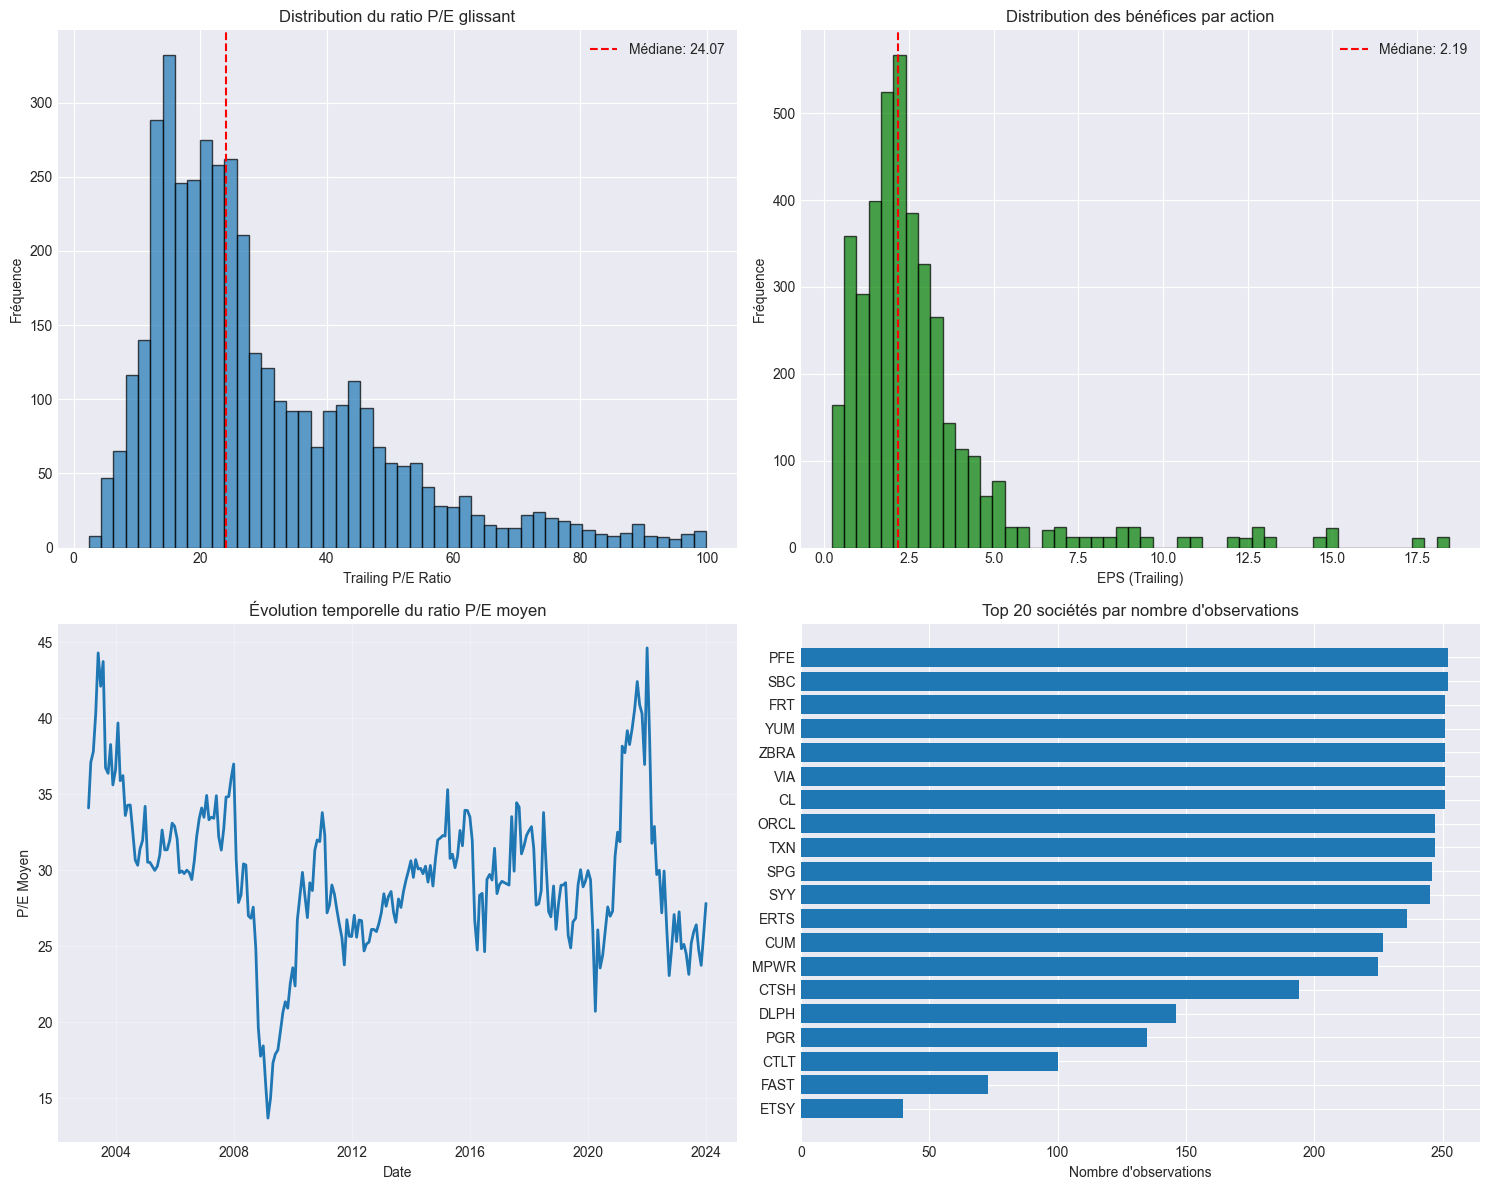

Graphiques générés avec succès!


In [ ]:
# Étape 10: Visualisations des données

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution du ratio P/E glissant
axes[0, 0].hist(final_data['trailing_pe'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Trailing P/E Ratio')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution du ratio P/E glissant')
axes[0, 0].axvline(final_data['trailing_pe'].median(), color='red', linestyle='--', 
                    label=f'Médiane: {final_data["trailing_pe"].median():.2f}')
axes[0, 0].legend()

# 2. Distribution des EPS
axes[0, 1].hist(final_data['eps'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('EPS (Trailing)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution des bénéfices par action')
axes[0, 1].axvline(final_data['eps'].median(), color='red', linestyle='--',
                    label=f'Médiane: {final_data["eps"].median():.2f}')
axes[0, 1].legend()

# 3. Évolution temporelle du P/E moyen
pe_by_date = final_data.groupby('date')['trailing_pe'].mean()
axes[1, 0].plot(pe_by_date.index, pe_by_date.values, linewidth=2)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('P/E Moyen')
axes[1, 0].set_title('Évolution temporelle du ratio P/E moyen')
axes[1, 0].grid(True, alpha=0.3)

# 4. Nombre d'observations par société
obs_per_company = final_data['ticker'].value_counts().head(20)
axes[1, 1].barh(range(len(obs_per_company)), obs_per_company.values)
axes[1, 1].set_yticks(range(len(obs_per_company)))
axes[1, 1].set_yticklabels(obs_per_company.index)
axes[1, 1].set_xlabel('Nombre d\'observations')
axes[1, 1].set_title('Top 20 sociétés par nombre d\'observations')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Graphiques générés avec succès!")

In [ ]:
# Étape 11: Sauvegarder les données pour utilisation future

# Sauvegarder le dataset final
final_data.to_csv('sp500_sample_data.csv', index=False)
print("Données sauvegardées dans 'sp500_sample_data.csv'")

# Sauvegarder aussi la liste des sociétés sélectionnées
selected_companies.to_csv('selected_companies.csv', index=False)
print("Liste des sociétés sauvegardée dans 'selected_companies.csv'")

# Résumé final
print("\n" + "="*70)
print("RÉSUMÉ FINAL DE L'EXTRACTION DES DONNÉES")
print("="*70)

print(f"\n✓ {len(selected_companies)} sociétés sélectionnées aléatoirement du S&P 500")
print(f"✓ {len(final_data)} observations mensuelles collectées")
print(f"✓ Période couverte: {final_data['date'].min().strftime('%Y-%m')} à {final_data['date'].max().strftime('%Y-%m')}")
print(f"✓ {final_data['ticker'].nunique()} sociétés avec données complètes")

print("\n✓ Variables extraites:")
print("  - Prix mensuels des actions (CRSP)")
print("  - Bénéfice par action - EPS trailing (IBES Actuals)")
print("  - Prévisions EPS - Expected EPS (IBES Consensus)")
print("  - Ratio P/E glissant (calculé)")
print("  - Ratio P/E forward (calculé)")
print("  - Capitalisation boursière")
print("  - Rendements mensuels")

print("\n✓ Données prêtes pour l'analyse de la stratégie 'Expected EPS × Trailing P/E'")

# Afficher un aperçu des données finales
print("\n" + "="*70)
print("APERÇU DES DONNÉES FINALES")
print("="*70)
print("\nPremières lignes du dataset final:")
print(final_data[['ticker', 'date', 'price', 'eps', 'expected_eps', 'trailing_pe', 'forward_pe']].head(15))

print("\n" + "="*70)

Données sauvegardées dans 'sp500_sample_data.csv'
Liste des sociétés sauvegardée dans 'selected_companies.csv'

RÉSUMÉ FINAL DE L'EXTRACTION DES DONNÉES

✓ 50 sociétés sélectionnées aléatoirement du S&P 500
✓ 4120 observations mensuelles collectées
✓ Période couverte: 2003-01 à 2023-12
✓ 20 sociétés avec données complètes

✓ Variables extraites:
  - Prix mensuels des actions (CRSP)
  - Bénéfice par action - EPS trailing (IBES Actuals)
  - Prévisions EPS - Expected EPS (IBES Consensus)
  - Ratio P/E glissant (calculé)
  - Ratio P/E forward (calculé)
  - Capitalisation boursière
  - Rendements mensuels

✓ Données prêtes pour l'analyse de la stratégie 'Expected EPS × Trailing P/E'

APERÇU DES DONNÉES FINALES

Premières lignes du dataset final:
   ticker       date  price   eps  expected_eps  trailing_pe  forward_pe
0    ORCL 2003-06-30  12.01  0.44          0.47    27.295455   25.553191
1    ORCL 2003-07-31  11.99  0.44          0.47    27.250000   25.510638
2    ORCL 2003-08-29  12.83  0

### Note sur l'adaptabilité du code

Le code ci-dessus est facilement adaptable pour un échantillon plus grand. Pour modifier la taille de l'échantillon, il suffit de changer la valeur de `n_companies` dans la cellule de configuration des paramètres.

**Pour un échantillon plus grand (par exemple, 100 ou 200 sociétés):**
```python
n_companies = 100  # ou 200, ou tout autre nombre
```

**Pour utiliser toutes les sociétés du S&P 500:**
```python
# Commenter ou supprimer la ligne de sélection aléatoire
# selected_companies = sp500_valid.sample(n=n_companies, random_state=42)

# Et utiliser à la place:
selected_companies = sp500_valid
```

Le reste du code s'adaptera automatiquement car il utilise les listes de PERMNOs et tickers générées dynamiquement.